# Make Nup107 PERPL analysis plots in Z

## Imports

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import modelling_general
import two_layer_fitting
import background_models
import modelstats

## Set standard maximum distance over which to plot distances and fit models

In [2]:
fitlength = 200.

## Load relative position data
### Insert path to the relative position data here:

In [5]:
nup107_relpos_path = r'../data-perpl/Nup107_SNAP_3D_GRROUPED_10nmZprec_PERPL-relpos_200.0filter.csv'


In [6]:
start_time = time.time()
relpos = np.loadtxt(nup107_relpos_path, delimiter=',', skiprows=1)
print('This took ' +repr(time.time() - start_time)+ ' s.')

This took 14.447729587554932 s.


### One data point and number of data points:

In [5]:
relpos[0] # This shows the first relative position.
# Distances are in X, Y, Z, XY, XZ, YZ, XYZ

array([ -69.19     , -196.07     , -100.0249931])

In [6]:
len(relpos) # This shows how many relative positions.

2004869

## Get Z distances and plot 1-nm bin histogram
Distances used up to fitlength.
Histogram scaled so that mean counts = 1, to suit the fitting algorithm.

Text(0, 0.5, 'Counts (scaled: mean = 1)')

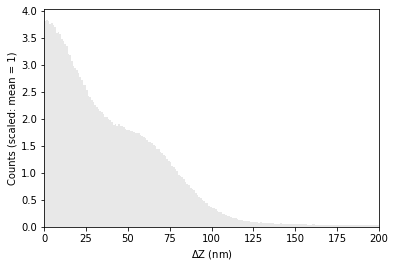

In [7]:
z_distances = np.abs(relpos[:, 2]) # Include all relative positions with negative z_distance (duplicates have removed by using only positive x_distance)
z_distances = z_distances[z_distances <= fitlength]
distance_histogram_values, bin_edges = np.histogram(
    z_distances,
    weights=np.repeat(float(fitlength) / len(z_distances),
                      len(z_distances)
                      ),
    bins=np.arange(fitlength + 1)
    )
plt.figure()
axes = plt.subplot(111)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 1.0
axes.bar(bin_centres,
         distance_histogram_values,
         align='center', width=width, alpha=0.5,                       color='lightgrey'
         )
axes.set_xlim([0, fitlength])
axes.set_xlabel(r'$\Delta$Z (nm)')
axes.set_ylabel('Counts (scaled: mean = 1)')

## Choose RPD model:

In [8]:
model = two_layer_fitting.two_layer_model_exp_decay_bg

## Fit model to histogram bin values, at bin centres

In [9]:
(params_optimised,
 params_covar,
 params_1sd_error) = two_layer_fitting.fit_two_layer_model(
                        distance_histogram_values,
                        model,
                        fitlength
                        )
print('Parameter estimates and uncertainties (stdev):')
print(np.column_stack((params_optimised, params_1sd_error)))

Parameter estimates and uncertainties (stdev):
[[5.81699065e+01 8.40901239e-02]
 [8.38091849e+01 1.27194982e+00]
 [7.41397188e+01 5.70761087e-01]
 [2.25887852e+01 4.97517061e-02]
 [8.04471456e-01 5.21729641e-02]
 [5.34855559e+01 1.47817421e+00]]


## Plot fitted model over histogram data

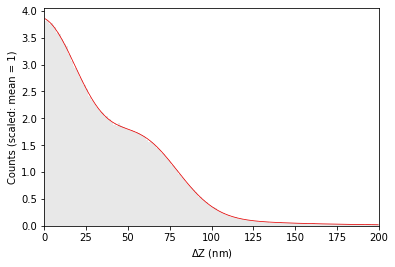

In [10]:
plt.figure()
axes = plt.subplot(111)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 1.0
axes.bar(bin_centres,
         distance_histogram_values,
         align='center', width=width, alpha=0.5,                       color='lightgrey'
         )
axes.set_xlim([0, fitlength])
axes.set_xlabel(r'$\Delta$Z (nm)')
axes.set_ylabel('Counts (scaled: mean = 1)')

# Plot model
axes.plot(bin_centres,
          model(bin_centres, *params_optimised),
          color='xkcd:red', lw=0.75
          )

## Plot fitted model over histogram data, with confidence intervals on the model
### NOTE: IT TAKES A WHILE TO CALCULATE THE CONFIDENCE INTERVALS
### Skip this if you don't need it right now.

Text(0.5, 1.0, "Best model: 'two_layer_model_exp_decay_bg'")

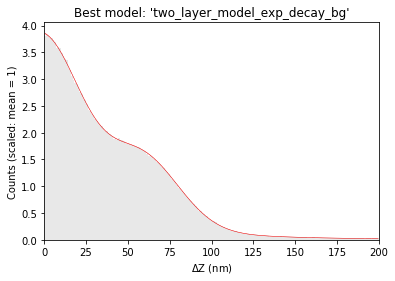

In [11]:
plt.figure()
axes = plt.subplot(111)
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
width = 1.0
axes.bar(bin_centres,
         distance_histogram_values,
         align='center', width=width, alpha=0.5,                       color='lightgrey'
         )
axes.set_xlim([0, fitlength])
axes.set_xlabel(r'$\Delta$Z (nm)')
axes.set_ylabel('Counts (scaled: mean = 1)')

# Plot model
axes.plot(bin_centres,
          model(bin_centres, *params_optimised),
          color='xkcd:red', lw=0.5
          )

# Find uncertainty (stdev) on model values,
# based on covariance of fitted parameters.
# Requires a version of the model that takes the arguments in a single vector
vector_input_model = two_layer_fitting.two_layer_model_exp_decay_bg_vectorargs
stdev = modelling_general.stdev_of_model(
    bin_centres,
    params_optimised,
    params_covar,
    vector_input_model)
# Plot 95% confidence intervals
axes.fill_between(bin_centres,
                  model(bin_centres, *params_optimised) - stdev * 1.96,
                  model(bin_centres, *params_optimised) + stdev * 1.96,
                  facecolor='xkcd:red',
                  alpha=0.25
                  )
axes.set_title('Best model: ' + repr(model.__name__))

## Akaike weights for the models
Typed in AICc values for the different models here, to obtain relative likelihood, summing to one:

In [12]:
from modelstats import akaike_weights
weights = akaike_weights([1.])
print(weights)

[1.]


## Plot model components

Text(0.5, 1.0, "Best model: 'two_layer_model_exp_decay_bg'")

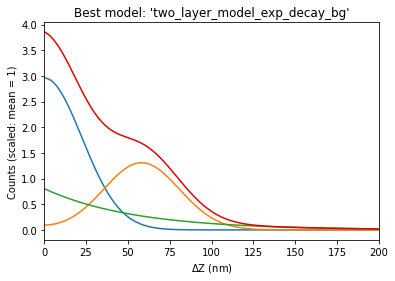

In [13]:
(layer_separation,
 amplitude_within_layer,
 amplitude_between_layers,
 broadening,
 bg_amplitude,
 bg_scale_param) = params_optimised

within_layer_peak = (
    amplitude_within_layer
    * modelling_general.pairwise_correlation_1d(
        bin_centres,
        0,
        broadening
        )
    )

between_layers_peak = (
    amplitude_between_layers
    * modelling_general.pairwise_correlation_1d(
        bin_centres,
        layer_separation,
        broadening
        )
    )

background = background_models.exponential_decay_1d_pair_corr(
    bin_centres,
    bg_amplitude,
    bg_scale_param
    )

full_model = within_layer_peak + between_layers_peak + background

plt.figure()
axes = plt.subplot(111)
axes.plot(bin_centres, within_layer_peak)
axes.plot(bin_centres, between_layers_peak)
axes.plot(bin_centres, background)
axes.plot(bin_centres, full_model, color='xkcd:red')

axes.set_xlim([0, fitlength])
axes.set_xlabel(r'$\Delta$Z (nm)')
axes.set_ylabel('Counts (scaled: mean = 1)')
axes.set_title('Best model: ' + repr(model.__name__))